In [27]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [28]:
words = open('../data/names.txt', 'r').read().splitlines()

In [29]:
len(words)

32033

In [30]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [31]:
chars = sorted(list(set(''.join(words))))

# util

In [32]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [33]:
stoi = {s: i for i, s in itos.items()}

# Build a neural language model

## prepare data

In [34]:
def build_dataset(data):
    block_size = 3
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [35]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Train a neural language model

In [36]:
C = torch.randn(len(itos), 2)
w1 = torch.randn(6, 300)
b1 = torch.randn(300)
w2 = torch.randn(300, len(itos))
b2 = torch.randn(len(itos))
parameters = [C, w1, b1, w2, b2]

In [37]:
sum(p.nelement() for p in parameters)

10281

In [38]:
for p in parameters:
    p.requires_grad = True

In [39]:
loglossi = []
lossi = []
for i in tqdm(range(50_000)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 25_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())

100%|██████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:18<00:00, 2648.17it/s]


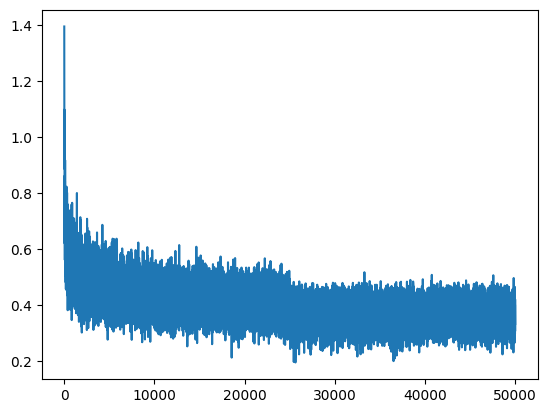

In [40]:
plt.plot(loglossi)

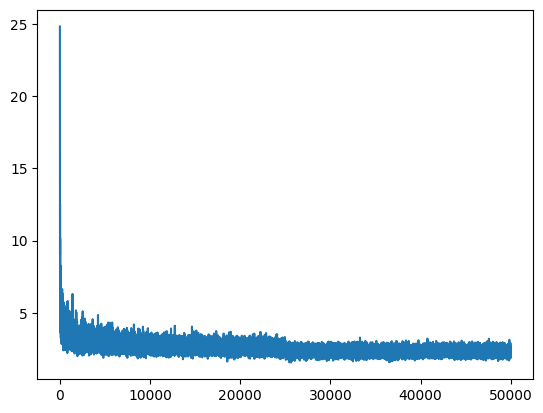

In [41]:
plt.plot(lossi)

## compute loss on train/dev/test

In [42]:
def eval_dataset(X, Y):
    with torch.no_grad():
        emb = C[X] # (32, 3, 2)
        h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
        logits = h @ w2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

In [43]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

2.316197156906128
2.323568105697632


## visualize the embedding

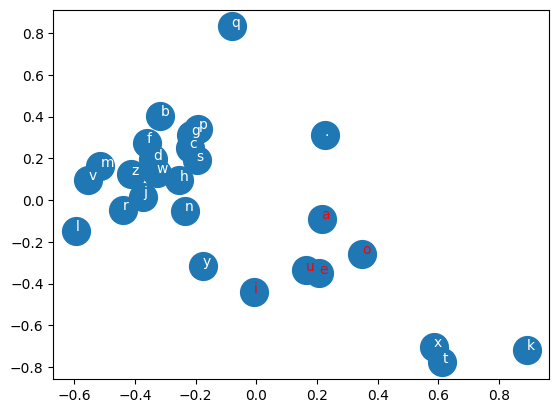

In [46]:
plt.scatter(C[:,0].data, C[:,1].data, s=400)
for i in range(C.shape[0]):
    if itos[i] in 'aeiou':
        c = 'red'
    else:
        c = 'white'
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], color=c)